In [27]:
# this is not part of our MVP

# # this code for the initialization process.
# we will be comparing two data frames at various levels of granularity

# the first is the output form Market_Characterization which has the initial counts of equipment by utility building type and end use?
# the second is real world forecasts from a utility. for this example we will used DTE's

# the first initialization stage will just be the present year

# we will clean the data frames to have the same structure and then compare them
# the comparison will be done by calculating the percentage difference between the two data frames at various levels of aggregation
# and the creation of bar graphs and stacked bar graphs to visualize the differences



In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [29]:
# read in the initial year values from Market_Characterization
df_yr1 = pd.read_pickle("./001_output/df_yr1_001.pkl")

In [30]:
def clean_column_names(df):
    df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace('$', 'usd').str.replace('/', 'per').str.replace('&', 'and').str.replace('.', '')
    return df

In [31]:
df_utility_forecast = pd.read_excel("./002_input/002_template_utilty_forecast_disagg.xlsx", sheet_name = "Sector_Forecast")
df_utility_forecast = clean_column_names(df_utility_forecast)

In [32]:
# drop all rows except the first one
df_utility_forecast = df_utility_forecast.iloc[:1]

In [33]:
res_stock_building_type_disagg = pd.read_excel("./002_input/002_template_utilty_forecast_disagg.xlsx", sheet_name = "Building_Type_Disagg")
res_stock_building_type_disagg = clean_column_names(res_stock_building_type_disagg)

In [34]:
res_stock_electric_disagg = pd.read_excel("./002_input/002_template_utilty_forecast_disagg.xlsx", sheet_name = "Electric_Enduse_Disagg")
res_stock_gas_disagg = pd.read_excel("./002_input/002_template_utilty_forecast_disagg.xlsx", sheet_name = "Gas_Enduse_Disagg")
clean_column_names(res_stock_electric_disagg)
clean_column_names(res_stock_gas_disagg)

,end_use,single_family,single_family_li,multifamily,multifamily_li
0,Space Heating,263596722.0,76286217.0,11409652.0,11228856.0
1,Water Heating,34037755.0,11127411.0,3217137.0,3848142.0
2,Cooking,NaN,NaN,NaN,NaN
3,Appliances,7598235.0,2260552.0,584664.0,605030.0
4,Process Heating,NaN,NaN,NaN,NaN
5,Process Other,NaN,NaN,NaN,NaN
6,Total Gas,NaN,NaN,NaN,NaN


In [35]:
# now we take the disagg files and change them from actual energy use and make them into a percentage by doing the sumproduct of each column and dividing by the total sum of the column

def disagg_to_percentage(df):
    df_perc = df.copy()
    for col in df_perc.columns:
        if col not in ['condition_name', 'sector', 'electric_utility', 'gas_utility', 'building_type', 'end_use']:
            total = df_perc[col].sum()
            if total > 0:
                df_perc[col] = df_perc[col] / total
            else:
                df_perc[col] = 0
    return df_perc


In [36]:
res_stock_electric_disagg_pct = disagg_to_percentage(res_stock_electric_disagg)
res_stock_gas_disagg_pct = disagg_to_percentage(res_stock_gas_disagg)
res_stock_electric_disagg_pct

,end_use,single_family,single_family_li,multifamily,multifamily_li
0,Appliances,0.069750,0.079149,0.063307,0.049860
1,Cooking,NaN,NaN,NaN,NaN
2,Cooling,0.178059,0.180642,0.129482,0.132366
3,Exterior Lighting,0.009293,0.009015,0.011466,0.011166
4,Interior Lighting,0.115996,0.102065,0.109696,0.101756
5,Other,0.039980,0.017792,0.013764,0.015009
6,Plug Loads,0.230905,0.243992,0.217100,0.220118
7,Refrigeration,0.070632,0.076680,0.063471,0.075558
8,Space Heating,0.198436,0.189590,0.284024,0.293106
9,Ventilation,NaN,NaN,NaN,NaN


In [37]:
# Keep only the kWh residential forecast column
# and extract the residential building-type disaggregation row

# Ensure the forecast has the expected column
if 'kwh_residential' not in df_utility_forecast.columns:
    raise KeyError('Expected column `kwh_residential` in df_utility_forecast')

# Reduce to single-row forecast and read the numeric value
df_utility_forecast = df_utility_forecast[['kwh_residential']].iloc[:1]
kwh_residential = float(df_utility_forecast['kwh_residential'].iloc[0]) if not pd.isna(df_utility_forecast['kwh_residential'].iloc[0]) else 0.0

# Select building-type columns (will raise if missing)
building_cols = ['single_family', 'multifamily', 'single_family_li', 'multifamily_li']
missing = [c for c in building_cols if c not in res_stock_building_type_disagg.columns]
if missing:
    raise KeyError(f'Missing expected building-type columns in res_stock_building_type_disagg: {missing}')

res_stock_building_type_disagg_residential_electric = res_stock_building_type_disagg[building_cols].iloc[:1]

# Convert to numeric fractions and normalize if necessary
bvals = res_stock_building_type_disagg_residential_electric.iloc[0].fillna(0).astype(float)
if bvals.sum() > 0:
    bfrac = bvals / bvals.sum()
else:
    # If all zeros, distribute evenly
    bfrac = pd.Series(1.0 / len(bvals), index=bvals.index)

# Multiply forecast kWh by building fractions to get kWh by building type
by_building_energy = (bfrac * kwh_residential).to_frame().T
by_building_energy.index = ['allocated_kwh_residential']

# Show result
by_building_energy

,single_family,multifamily,single_family_li,multifamily_li
allocated_kwh_residential,2.119018e+10,3.126421e+09,9.031882e+09,1.389520e+09


In [38]:
# now I want to further disaggregate this by end use using the res_stock_electric_disagg_pct dataframe
# the res_stock_electric_disagg_pct dataframe is structured such that each row is an enduse and each column is a building type
# multiply each building-type column by the corresponding value in by_building_energy to get allocated kWh by end use and building type
# prepare the end-use percentage dataframe (ensure end_use is the index if present)
if 'end_use' in res_stock_electric_disagg_pct.columns:
    enduse_pct = res_stock_electric_disagg_pct.set_index('end_use').copy()
else:
    enduse_pct = res_stock_electric_disagg_pct.copy()

# building columns used earlier; ensure they exist in the enduse percentage table
building_cols = ['single_family', 'multifamily', 'single_family_li', 'multifamily_li']
missing_buildings = [c for c in building_cols if c not in enduse_pct.columns]
if missing_buildings:
    raise KeyError(f'Missing expected building-type columns in enduse percentage table: {missing_buildings}')

# select only the building-type columns and coerce to numeric fractions
enduse_pct_building = enduse_pct[building_cols].astype(float).fillna(0)

# extract the by-building kWh series from the single-row dataframe created earlier
if 'allocated_kwh_residential' in by_building_energy.index:
    by_building_series = by_building_energy.loc['allocated_kwh_residential']
else:
    # if the index differs, take the first row as a fallback
    by_building_series = by_building_energy.iloc[0]

# reindex the series to the building columns to ensure alignment and fill missing with 0
by_building_series = by_building_series.reindex(building_cols).astype(float).fillna(0)

# multiply percentages by kWh per building type to get allocated kWh by end use (rows) and building type (cols)
allocated_kwh = enduse_pct_building.multiply(by_building_series, axis=1)

# Sanity checks: totals should sum to the original residential kWh forecast (kwh_residential)
total_allocated = allocated_kwh.values.sum()
print(f'kwh_residential (input): {kwh_residential}')
print(f'total_allocated (computed): {total_allocated}')

# Add summary rows/cols for easy inspection (do not modify allocated_kwh itself)
allocated_kwh_with_totals = allocated_kwh.copy()
allocated_kwh_with_totals['enduse_total_kwh'] = allocated_kwh_with_totals.sum(axis=1)
allocated_kwh_with_totals.loc['building_total_kwh'] = allocated_kwh_with_totals.sum(axis=0)

# show the allocated kWh table and the totals summary
allocated_kwh_with_totals

kwh_residential (input): 34738007899.09
total_allocated (computed): 34738007899.09


,single_family,multifamily,single_family_li,multifamily_li,enduse_total_kwh
end_use,,,,,
Appliances,1.478019e+09,1.979228e+08,7.148642e+08,6.928154e+07,2.460088e+09
Cooking,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Cooling,3.773106e+09,4.048144e+08,1.631535e+09,1.839247e+08,5.993380e+09
Exterior Lighting,1.969229e+08,3.584904e+07,8.142212e+07,1.551503e+07,3.297091e+08
Interior Lighting,2.457968e+09,3.429573e+08,9.218371e+08,1.413923e+08,3.864154e+09
Other,8.471825e+08,4.303133e+07,1.606922e+08,2.085489e+07,1.071761e+09
Plug Loads,4.892923e+09,6.787473e+08,2.203705e+09,3.058590e+08,8.081234e+09
Refrigeration,1.496712e+09,1.984373e+08,6.925642e+08,1.049900e+08,2.492704e+09
Space Heating,4.204900e+09,8.879774e+08,1.712358e+09,4.072769e+08,7.212512e+09


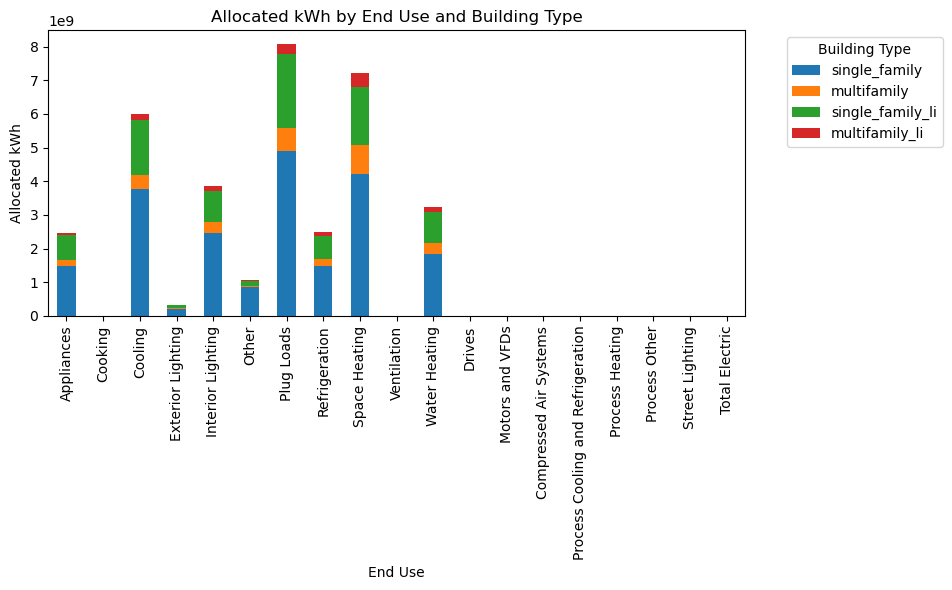

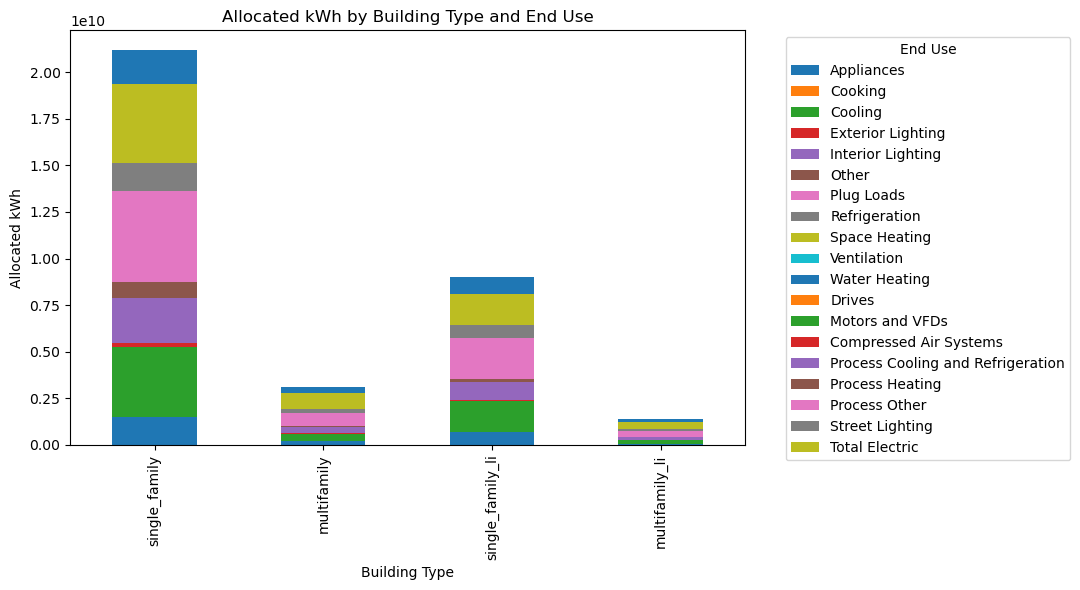

In [39]:
# now make a bar graph of the allocated kWh by end use and building type
ax = allocated_kwh.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Allocated kWh by End Use and Building Type')
plt.xlabel('End Use')
plt.ylabel('Allocated kWh')
# move legend outside to the right
plt.legend(title='Building Type', bbox_to_anchor=(1.05, 1), loc='upper left')
# adjust the plot area to make room for the legend
plt.tight_layout()
plt.subplots_adjust(right=0.75)
plt.show()

# make another graph showing the total allocated kWh with building type on the x axis
ax2 = allocated_kwh.T.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Allocated kWh by Building Type and End Use')
plt.xlabel('Building Type')
plt.ylabel('Allocated kWh')
# move legend outside to the right
plt.legend(title='End Use', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.subplots_adjust(right=0.75)
plt.show()

In [40]:
condition_input = pd.read_excel("./002_input/002_condition_energy_usage_template_20251121_113407.xlsx", sheet_name = "Sheet1")
condition_input = clean_column_names(condition_input)
# group this dataframe by end use and building type and sum the annual_electric_energy
condition_input = condition_input.groupby(['end_use', 'building_type'])['annual_electric_energy_kwh'].sum().unstack()
# multiply annual_electric_energy_kwh by 1000000
condition_input = condition_input * 1000000
condition_input

building_type,multi_family,multi_family_li,single_family,single_family_li
end_use,,,,
appliances,NaN,NaN,2.900000e+09,NaN
cooking,NaN,NaN,9.000000e+08,NaN
cooling,1.003500e+10,1.003500e+10,9.146000e+09,8.180000e+09
exterior_lighting,NaN,NaN,4.500000e+08,NaN
interior_lighting,NaN,NaN,2.400000e+09,NaN
other,NaN,NaN,6.000000e+08,NaN
plug_loads,NaN,NaN,3.600000e+09,NaN
refrigeration,7.500000e+09,7.500000e+09,6.300000e+09,4.500000e+09
space_heating,5.559118e+09,5.559118e+09,4.784000e+09,4.140000e+09


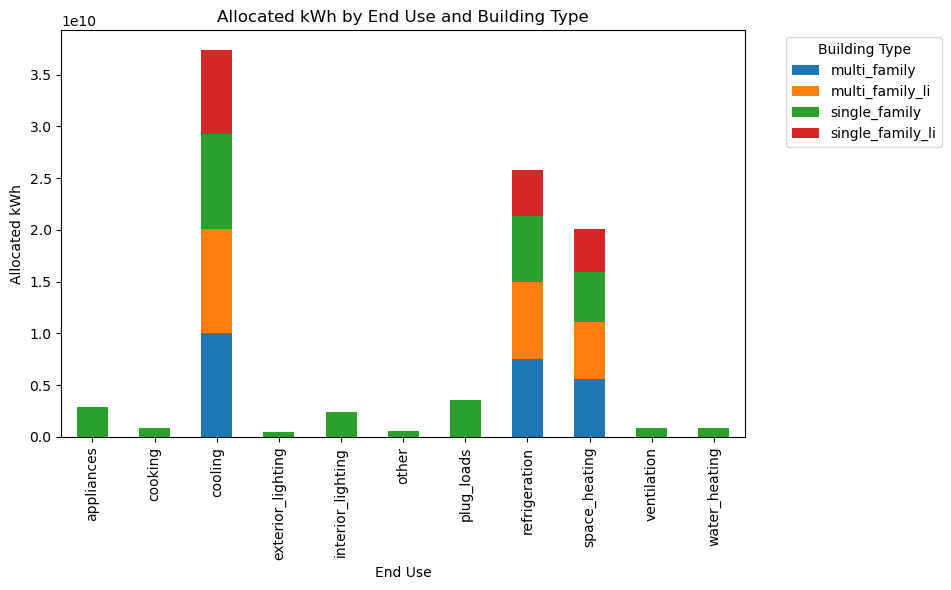

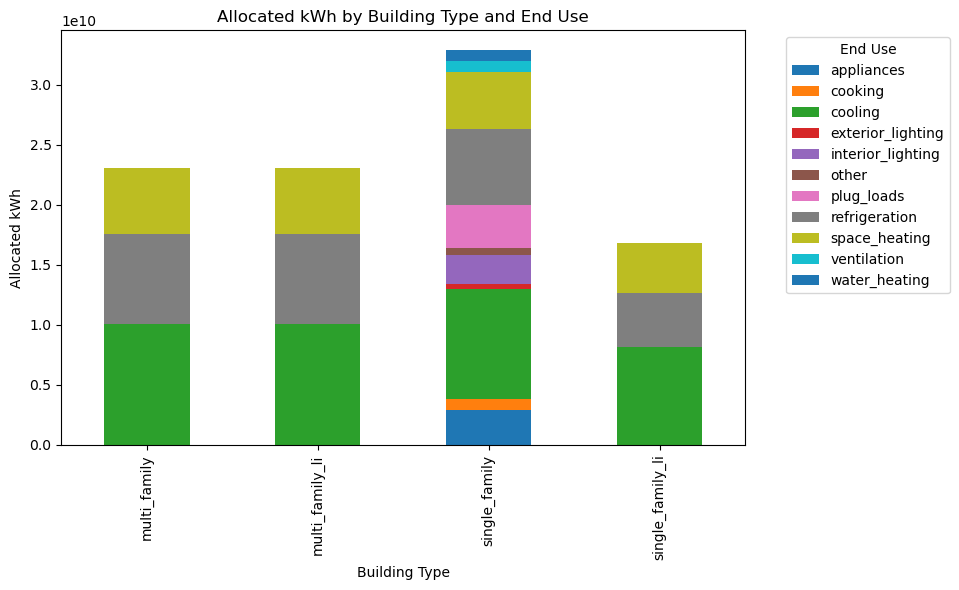

In [41]:
# now make a bar graph of the allocated kWh by end use and building type
ax = condition_input.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Allocated kWh by End Use and Building Type')
plt.xlabel('End Use')
plt.ylabel('Allocated kWh')
# move legend outside to the right
plt.legend(title='Building Type', bbox_to_anchor=(1.05, 1), loc='upper left')
# adjust the plot area to make room for the legend
plt.tight_layout()
plt.subplots_adjust(right=0.75)
plt.show()

# make another graph showing the total allocated kWh with building type on the x axis
ax2 = condition_input.T.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Allocated kWh by Building Type and End Use')
plt.xlabel('Building Type')
plt.ylabel('Allocated kWh')
# move legend outside to the right
plt.legend(title='End Use', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.subplots_adjust(right=0.75)
plt.show()

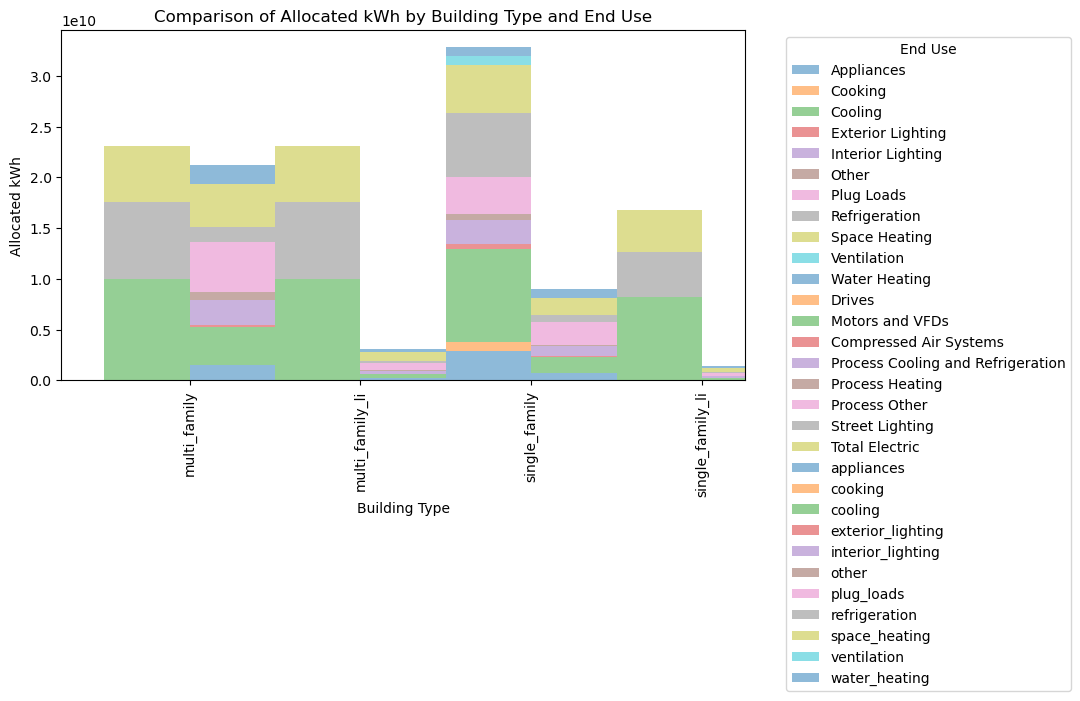

In [42]:
# plot both ax2 = condition_input.T.plot(kind='bar', stacked=True, figsize=(10, 6)) and ax2 = allocated_kwh.T.plot(kind='bar', stacked=True, figsize=(10, 6)) on the same graph for comparison
ax3 = allocated_kwh.T.plot(kind='bar', stacked=True, figsize=(10, 6), alpha=0.5, position=0)
condition_input.T.plot(kind='bar', stacked=True, figsize=(10, 6), alpha=0.5, position=1, ax=ax3)
plt.title('Comparison of Allocated kWh by Building Type and End Use') 
plt.xlabel('Building Type')
plt.ylabel('Allocated kWh')
# move legend outside to the right
# combine legends from both plots
handles1, labels1 = ax3.get_legend_handles_labels()
handles2, labels2 = ax3.get_legend_handles_labels()
all_handles = handles1 + handles2
all_labels = labels1 + labels2
plt.legend(all_handles, all_labels, title='End Use', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.legend(title='End Use', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.subplots_adjust(right=0.75)
plt.show()
#       